In [1]:
#This is based on:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8759878
#codebase is from:
# https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

In [9]:
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import os
import sys
from ecgdetectors import Detectors
from scipy import signal as siglib

(9000, 1)
(9000,)


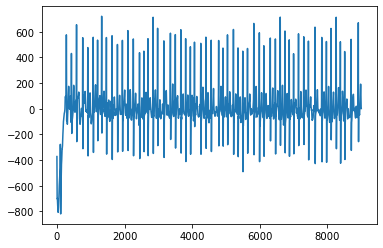

In [4]:
#load a testsample
data = sio.loadmat('training/'+'train_ecg_00097'+'.mat')
signal = data['val'].T
print(signal.shape)
signal = np.ravel(signal)
print(signal.shape)
plt.plot(signal) 
plt.show()

In [5]:
fs = 300

The start and end index are:  900 8100
The new length of the signal is:  7200


<function matplotlib.pyplot.show(close=None, block=None)>

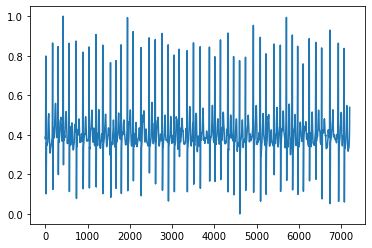

In [113]:
#cutoff the first and last 3 seconds of the signal
startindex = fs * 3 #seconds
endindex = signal.size - startindex
print("The start and end index are: ",startindex, endindex)
cutsignal = signal[startindex:endindex]
print("The new length of the signal is: ",cutsignal.size)

#normalise signalvalues
normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))

#plot the cut and normalised signal
plt.plot(normalisesignal)
plt.show

(257, 32)

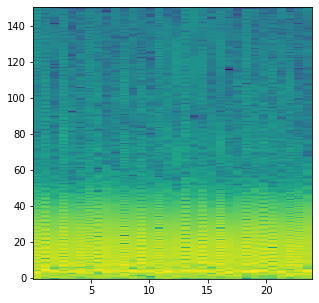

In [114]:
from scipy import signal as siglib
from scipy.fft import fftshift
np.set_printoptions(threshold=sys.maxsize)

plt.figure(figsize=(5,5))
f,t, Sxx = siglib.spectrogram(normalisesignal, fs=300, nfft=512)

plt.pcolor(t, f, 10*np.log10(Sxx))
Sxx.shape

In [6]:
#Preprocessing of the incoming data
#the signal is cut before the first and after the last detected r_peak if it is to short
#than the signal is repeated multiple times to reach the desired length
#afterwards the signal is normalized

def preprocessData(data,targetsize,samplefreq,debug):
    ret_signal = 0
    repeat_signal = 0
    #looking for r_peaks and repeating the signal
    if(data.size < targetsize):
        if(debug): print('Length of the signal ->'+str(data.size)+'<- is shorter than '+str(targetsize))
        detector = Detectors(samplefreq)
        try:
            r_peaks = detector.hamilton_detector(data)
            if(debug): print('R-Peaks are detected!')
            repeat_signal = data[r_peaks[0]:r_peaks[-1]]
        except:
            if(debug): print('R-Peaks could not be detected!')
            repeat_signal = data
        
        if(repeat_signal.size == 0):
            if(debug): print('Something went wrong, just use the original signal to repeat.')
            repeat_signal = data
            if(debug and repeat_signal.size == 0): print('I have no idea.')
        repeats = int(np.ceil(targetsize / repeat_signal.size))
        if(debug): print('Signal is repeated ' + str(repeats) + ' times.')
        for i in range(repeats):
            ret_signal = np.append(ret_signal,repeat_signal)
    else:
        if(debug): print('Length of the signal ->'+str(data.size)+'<- is bigger than '+str(targetsize))
        ret_signal = data
        
    #cutting the signal to the desired length
    #same ammount is cut at the start and the end of the signal
    if(ret_signal.size > targetsize):
        if(debug): print('Signal is cut to length: ' + str(targetsize))
        cutindex   = int(((ret_signal.size-targetsize)/2))
        ret_signal = ret_signal[cutindex:-1]
        ret_signal = ret_signal[0:targetsize]
        if(debug): print('Size of the new signal: ' + str(ret_signal.size))
    
    #normalising the signal
    ret_signal = (ret_signal - np.min(ret_signal)) / (np.max(ret_signal) - np.min(ret_signal))
    
    return ret_signal

In [10]:
import pickle
def spectro(source, target, multi=True):
    id=0
    nnamez=dict()
    with open(source+'/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
        print(source+'/REFERENCE.csv')
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            data = sio.loadmat(source+'/'+row[0]+'.mat')   # Import der EKG-Dateien
            signal = data['val'][0]
            signal = np.ravel(signal)
            signal = preprocessData(signal, 9000, fs, False)
        # Sxx, f, t, im = plt.specgram(normalisesignal, NFFT=512, Fs=300, xextent=(0,30))
            f,t, Sxx = siglib.spectrogram(signal, fs=300, nfft=512)
            Sxx = 10*np.log10(Sxx+1e-12)
            Sxx = np.reshape(Sxx, (Sxx.shape[0],Sxx.shape[1],1))
            
            np.save(target+'/data/'+str(id), Sxx)
            
            if row[1]=='N': # Zuordnung zu "Normal"
                nlbl=np.asarray([1,0,0,0])
                np.save(target+'/label/'+str(id), nlbl)
        
            if row[1]=='A': 
                albl=np.asarray([0,1,0,0])             # Zuordnung zu "Vorhofflimmern"
                np.save(target+'/label/'+str(id), albl)

            if multi==True:
                if row[1]=='~':                        # Zuordnung zu "Noise"
                    wlbl=np.asarray([0,0,1,0])
                    np.save(target+'/label/'+str(id), wlbl)

            
                if row[1]=='O':                        # Zuordnung zu "Other"
                    olbl=np.asarray([0,0,0,1])
                    np.save(target+'/label/'+str(id), olbl)
                         
            id=id+1
            del data, signal, Sxx, f,t
            
            line_count = line_count + 1
            if (line_count % 100)==0:
                print(str(line_count) + "\t Dateien wurden verarbeitet.")
    

In [11]:
spectro('training','Preproces', True)

training/REFERENCE.csv
100	 Dateien wurden verarbeitet.
200	 Dateien wurden verarbeitet.
300	 Dateien wurden verarbeitet.
400	 Dateien wurden verarbeitet.
500	 Dateien wurden verarbeitet.
600	 Dateien wurden verarbeitet.
700	 Dateien wurden verarbeitet.
800	 Dateien wurden verarbeitet.
900	 Dateien wurden verarbeitet.
1000	 Dateien wurden verarbeitet.
1100	 Dateien wurden verarbeitet.
1200	 Dateien wurden verarbeitet.
1300	 Dateien wurden verarbeitet.
1400	 Dateien wurden verarbeitet.
1500	 Dateien wurden verarbeitet.
1600	 Dateien wurden verarbeitet.
1700	 Dateien wurden verarbeitet.
1800	 Dateien wurden verarbeitet.
1900	 Dateien wurden verarbeitet.
2000	 Dateien wurden verarbeitet.
2100	 Dateien wurden verarbeitet.
2200	 Dateien wurden verarbeitet.
2300	 Dateien wurden verarbeitet.
2400	 Dateien wurden verarbeitet.
2500	 Dateien wurden verarbeitet.
2600	 Dateien wurden verarbeitet.
2700	 Dateien wurden verarbeitet.
2800	 Dateien wurden verarbeitet.
2900	 Dateien wurden verarbeitet.


In [12]:
def load_batch(Xdat,Ydat,sbatch, ebatch):
    Xbat = []
    Ybat = []
    with open(Xdat, 'rb') as dat, open(Ydat, 'rb') as lab:
        for k in range(sbatch,ebatch):
            Xbat.append(pickle.load(dat))
            Ybat.append(pickle.load(lab))
            k=k+1
    Xbat=np.asarray(Xbat)
    Ybat=np.asarray(Ybat)
    return Xbat, Ybat



    

In [14]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(257,40), n_channels=1,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #print(ID)
            # Store sample
            X[i,] = np.load('Preproces/data/' + str(int(ID)) + '.npy')
            # Store class
            y[i] = np.load('Preproces/label/' + str(int(ID)) + '.npy')

        return X, y

In [15]:
import random
from keras.models import Sequential
#from my_classes import DataGenerator

# Parameters
params = {'dim': (257,40),
          'batch_size': 16,
          'n_classes': 4,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = np.arange(0,6000,1)
random.shuffle(partition)

# Generators
training_generator = DataGenerator(partition[0:5000], **params)
validation_generator = DataGenerator(partition[5000:6000], **params)

In [16]:
partition[0:2]

array([3955, 2413])

In [17]:
print(training_generator.__getitem__(0)[0][9].shape)

(257, 40, 1)


[0. 1.]


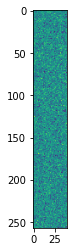

In [125]:
for images, labels in train_dataset.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    print(numpy_labels[1])
    plt.imshow(numpy_images[1])

(257, 40, 1)


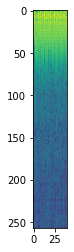

In [19]:
ID=4
plt.imshow(np.load('Preproces/data/4.npy'))
np.load('Preproces/label/4.npy')
print(np.load('Preproces/data/4.npy').shape)
#print(np.load('Preproces/data/' + str(int(ID)) + '.npy'))

-13.66966944450207


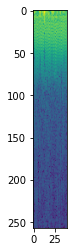

In [20]:
print(np.max(training_generator.__getitem__(4)[0][5]))
plt.imshow(training_generator.__getitem__(4)[0][5])

In [26]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(257,40,1)))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 257, 40, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 20, 32)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 20, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 10, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 5, 128)      

In [35]:
from tensorflow.keras import layers

def Xmodel(size):
    inputs = keras.Input(shape=size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [32, 64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

        x=layers.Flatten()(x)
        x=layers.Dense(256, activation='relu')(x)
        x=layers.Dense(64, activation='relu')(x)
        outputs=layers.Dense(4, activation='softmax')(x)

        model = keras.Model(inputs, outputs)
        return model

In [36]:
model = Xmodel((257,40,1))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 257, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 129, 20, 16)  160         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 129, 20, 16)  64         ['conv2d_13[0][0]']              
 rmalization)                                                                                     
                                                                                            

In [34]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=2)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

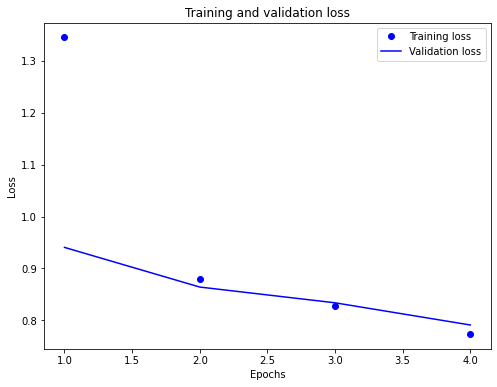

In [131]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

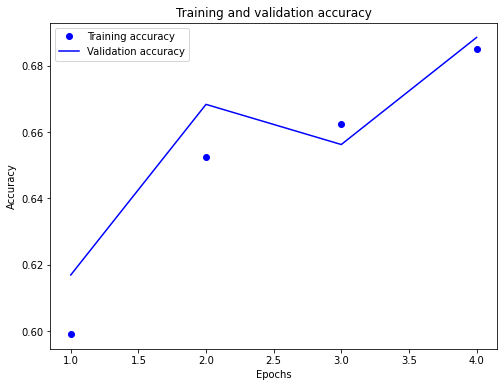

In [132]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()